# Tendencies of Housing Prices in NYC

The goal of this project is to gain insight into NYC housing prices applying some statistical methods, as well as to highlight pricing tendencies depending on a range of factors with the help of Multiple Linear Regression Model. 

The data on one-bedroom apartments in three of the five New York City boroughs: Brooklyn, Manhattan, and Queens is collected by codecademy from Streeteasy.com. Considering that "Streeteasy" is only used by a subset of property owners we can not assume that these prices are representative for the entire borough, but hopefully it will give us understanding of at least some trends in NYC apartment market. 

### Data Investigation & Cleaning
First we import libraries and upload csv files to variables for further work. 

In [1]:
# Basic imports related to analysis
import pandas as pd
import numpy as np
# Imports for visualisation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px

# Imports for ml
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


brooklyn = pd.read_csv('brooklyn-one-bed.csv')
manhattan = pd.read_csv('manhattan-one-bed.csv')
queens = pd.read_csv('queens-one-bed.csv')

Let's see what these files contain. 

In [2]:
# Display all columns
pd.set_option('display.max_columns', None)
brooklyn.head(3)

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,borough
0,2869,3600,3.0,2,900,4,1.0,15,1,0,0,0,0,0,0,0,Williamsburg,Brooklyn
1,4318,3900,3.0,2,1000,4,9.0,8,0,0,0,0,1,0,0,0,Greenwood,Brooklyn
2,6265,2700,2.0,1,900,4,2.0,96,0,0,0,0,0,0,0,0,Gowanus,Brooklyn


In [3]:
manhattan.head(3)

,rental_id,rental_id.1,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,3,2919,76909719,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,All Midtown,Manhattan
1,4,2790,92953520,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,All Downtown,Manhattan
2,15,1437,66221183,4650,1.0,1,915,5,5.0,106,0,0,0,0,0,0,0,0,Upper East Side,All Upper East Side,Manhattan


In [4]:
queens.head(3)

,rental_id,rental_id.1,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,6,10524,60898078,1950,1.0,1,950,1,3.0,83,0,0,0,0,0,0,0,0,Forest Hills,Central Queens,Queens
1,8,5465,73060494,3500,1.0,1,996,9,7.0,3,1,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens
2,21,5259,2540088,1725,1.0,1,800,1,2.0,89,0,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens


Considering that we are going to use this data to feed the ml algo we need it to be in one `df`. So we are going to concatenate 3 `df`s to one big, truncating some unnecessary fields in the process. 

In [5]:
def concatenate(datasets):
    columns = [
        'borough',
        'rent',
        'bedrooms',
        'bathrooms',
        'size_sqft',
        'min_to_subway', 
        'floor', 
        'building_age_yrs', 
        'has_roofdeck', 
        'has_elevator', 
        'has_dishwasher',
        'has_patio',
        'has_doorman', 
        'has_gym', 
        'neighborhood'        
        ]
    return pd.concat([dataset[columns] for dataset in datasets]).reset_index(drop=True)

nyc_flats = concatenate([manhattan, queens, brooklyn])
nyc_flats.head(3)

,borough,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,has_roofdeck,has_elevator,has_dishwasher,has_patio,has_doorman,has_gym,neighborhood
0,Manhattan,4500,1.0,1,916,2,51.0,29,1,1,1,0,1,0,Midtown
1,Manhattan,4795,1.0,1,975,3,8.0,31,0,1,1,0,1,1,Greenwich Village
2,Manhattan,4650,1.0,1,915,5,5.0,106,0,0,0,0,0,0,Upper East Side


In [6]:
nyc_flats.tail(3)

,borough,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,has_roofdeck,has_elevator,has_dishwasher,has_patio,has_doorman,has_gym,neighborhood
2718,Brooklyn,4000,2.0,1,1080,5,1.0,117,0,0,0,0,0,0,Williamsburg
2719,Brooklyn,4200,2.0,2,977,1,5.0,5,0,0,0,0,0,0,Downtown Brooklyn
2720,Brooklyn,18000,3.0,2,2470,3,5.0,116,1,1,1,0,1,1,DUMBO


In [7]:
nyc_flats.dtypes

borough              object
rent                  int64
bedrooms            float64
bathrooms             int64
size_sqft             int64
min_to_subway         int64
floor               float64
building_age_yrs      int64
has_roofdeck          int64
has_elevator          int64
has_dishwasher        int64
has_patio             int64
has_doorman           int64
has_gym               int64
neighborhood         object
dtype: object

In [8]:
nyc_flats.isnull().values.any()

False

In [9]:
nyc_flats.rent.describe()

count     2721.000000
mean      3605.058067
std       1458.603911
min       1275.000000
25%       2675.000000
50%       3450.000000
75%       4200.000000
max      18000.000000
Name: rent, dtype: float64

In [10]:
nyc_flats.groupby('borough').rent.mean()

borough
Brooklyn     3327.403751
Manhattan    3993.476965
Queens       2346.254310
Name: rent, dtype: float64

<AxesSubplot:xlabel='rent', ylabel='Count'>

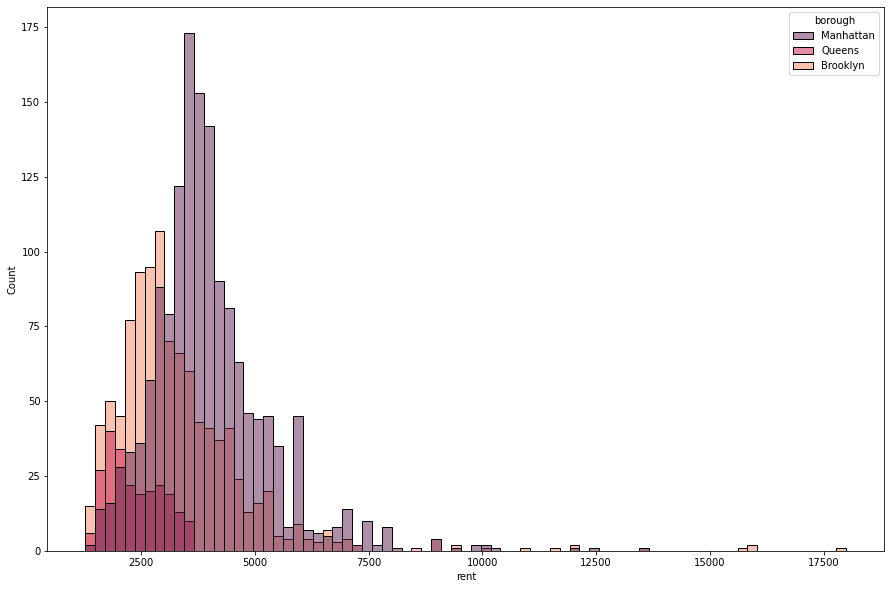

In [11]:
plt.figure(figsize=(15,10))
sns.histplot(data=nyc_flats, x='rent', hue='borough', palette='rocket')

In [12]:
fig = px.scatter_3d(nyc_flats, x='size_sqft', y='building_age_yrs', z='rent', color='borough', width=1100, height=1000)
fig.update_traces(marker={'size': 3})
fig.show()

Multiple Linear Regression uses two or more independent variables to predict the values of the dependent variable. We are going to try using `size_sqft` and `building_age_yrs` to understand rent dependency from these 2 features. 

In [13]:
regr = LinearRegression()

In [14]:
X = nyc_flats[['size_sqft', 'building_age_yrs']]
y = nyc_flats[['rent']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=12)

In [16]:
regr.fit(X_train, y_train)

LinearRegression()

Text(0.5, 0, 'Rent($)')

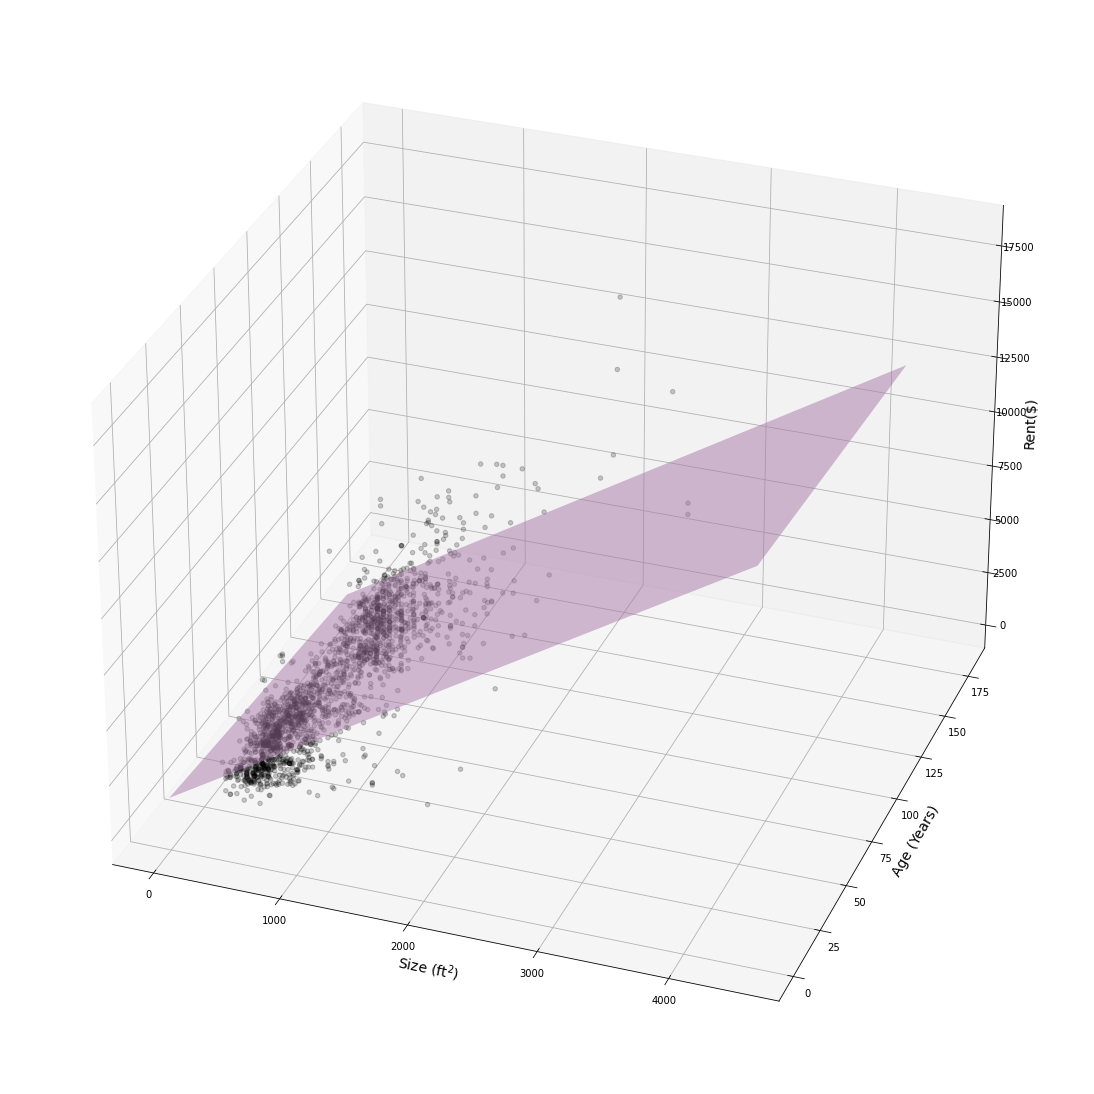

In [17]:
elev = 30
azim = -70
# sns.set(style='darkgrid')
fig = plt.figure(figsize=(20,15))

ax = Axes3D(fig, elev=elev, azim=azim, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(X_train[['size_sqft']], X_train[['building_age_yrs']], y_train, c='k', marker='o', alpha=0.2)

ax.plot_surface(
    np.array([[0,0], [4500, 4500]]), 
    np.array([[0, 140], [0, 140]]), 
    regr.predict(pd.DataFrame(np.array([[0, 0, 4500, 4500], [0, 140, 0, 140]]).T, columns=['size_sqft', 'building_age_yrs'])).reshape((2,2)), 
    alpha=.5, color='plum')

ax.set_xlabel('Size (ft$^2$)', fontsize=14)
ax.set_ylabel('Age (Years)', fontsize=14)
ax.set_zlabel('Rent($)', fontsize=14)

In [28]:
import plotly.graph_objects as go

v = regr.predict(pd.DataFrame(np.array([[0, 0, 4500, 4500], [0, 140, 0, 140]]).T, columns=['size_sqft', 'building_age_yrs'])).reshape((2,2))
f = go.Figure(
    list(px.scatter_3d(nyc_flats, x='size_sqft', y='building_age_yrs', z='rent', color='borough', size='rent', size_max=35).data) +
    [go.Surface(x=np.array([[0,0], [4500, 4500]]), y=np.array([[0, 140], [0, 140]]), z=v, opacity=0.5)]
)
f.update_layout(margin=dict(l=0, r=0, b=0, t=0))
f.show()